# Apply model to test areas

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import gridspec
import datacube

In [2]:
import numpy as np
from scipy import ndimage
from astropy.convolution import convolve
from skimage.morphology import disk

In [3]:
import xarray as xr
import os

In [4]:
plt.rcParams.update({'axes.labelsize': 8, 'axes.titlesize':8, 'font.size':8,
                     'legend.fontsize':6 ,'legend.handlelength':1})

# Supervised

In [5]:
from s1_thresholding import threshold_vv, threshold_vh

In [6]:
import itertools
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score

from imblearn.datasets import fetch_datasets
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.ensemble import RUSBoostClassifier
from imblearn.metrics import geometric_mean_score

from joblib import dump, load

def plot_confusion_matrix(cm, classes, ax,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          flat=False,
                         ):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #print(cm)
    #print('')

    if normalize:
        cm = cm/cm.sum(axis=1)[:,np.newaxis]
    
    if flat:
        ax.imshow(cm.repeat(2, axis=1), interpolation='nearest', cmap=cmap)
    else:
        ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    if flat:
        xtick_marks = np.arange(len(classes))*2+0.5
    else: 
        xtick_marks = np.arange(len(classes))
    ytick_marks = np.arange(len(classes))
    plt.xticks(xtick_marks, classes, rotation=45)
    plt.sca(ax)
    plt.yticks(ytick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if flat:
            ax.text(j*2+0.5, i, format(cm[i, j], fmt),
                horizontalalignment="center", verticalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
        else:
            ax.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center", verticalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')


In [7]:
!ls apsar_*.joblib
!ls apsar_classified_*.nc

apsar_brf_base.joblib  apsar_brf_rel.joblib	   apsar_rusboost.joblib
apsar_brf_ind.joblib   apsar_rusboost_base.joblib  apsar_rusboost_rel.joblib
apsar_brf.joblib       apsar_rusboost_ind.joblib
apsar_classified_base_george.nc
apsar_classified_base_tasmania.nc
apsar_classified_fortest_base_george.nc
apsar_classified_fortest_base_tasmania.nc
apsar_classified_fortest_ind_george.nc
apsar_classified_fortest_ind_tasmania.nc
apsar_classified_fortest_rel_george.nc
apsar_classified_fortest_rel_tasmania.nc
apsar_classified_ind_george.nc
apsar_classified_ind_tasmania.nc
apsar_classified_rel_george.nc
apsar_classified_rel_tasmania.nc


In [8]:
feature_set ='rel'

brf=load('apsar_brf_%s.joblib'%feature_set)
rusboost=load('apsar_rusboost_%s.joblib'%feature_set)

In [9]:
def make_data(area, addfeature=True):
    clean_1 = xr.open_dataset('apsar_s1_water_train_s1_%s.nc'%area)
    if addfeature:
        # all to dB
        clean_1['vh']=np.log10(clean_1.vh)*10.
        clean_1['vv']=np.log10(clean_1.vv)*10.
        clean_1['vv/vh']=clean_1.vv/clean_1.vh
        clean_1['vv+vh']=clean_1.vv + clean_1.vh
        clean_1['vv-vh']=clean_1.vv - clean_1.vh
        for band in ['vh','vv','vv/vh','vv+vh','vv-vh']:
            mean = clean_1[band].groupby('time').mean()
            clean_1[band+'_rel'] = clean_1[band]/mean
    clean_1['water'] = ('time','y','x'), xr.open_dataset('apsar_s1_water_train_wofs_%s.nc'%area).water
    return clean_1

# Apply model to all pixels in training area

In [10]:
from datacube.drivers import netcdf

def classify_all(area, feature_set):
    feature_sets = {'base':['vv','vh'],
                'ind': ['vv','vh','vv/vh','vv+vh', 'vv-vh'],
                'rel':['vv','vh','vv/vh','vv+vh', 'vv-vh','vv_rel','vh_rel','vv/vh_rel','vv+vh_rel', 'vv-vh_rel']}

    features = feature_sets[feature_set]
    clean_classified = 'apsar_classified_%s_%s.nc'%(feature_set, area)
    clean_result = 'apsar_classified_fortest_%s_%s.nc'%(feature_set, area)
    if os.path.exists(clean_classified) and os.path.exists(clean_result):
        clean_1 = xr.open_dataset(clean_classified,decode_times=False)
        result = xr.open_dataset(clean_result,decode_times=False)
    else: 
        clean_1 = make_data(area)
        clean_1_orig = make_data(area, addfeature=False)
        del clean_1['crs']
        
        data = clean_1[features].to_array(dim='variable').transpose('x','y','time', 'variable').values
        orig_shape = data.shape
        data = data.reshape(orig_shape[0]*orig_shape[1]*orig_shape[2],orig_shape[3])
        bad = np.isnan(data).any(axis=-1)
        data[bad,:]=0

        classified = brf.predict(data)
        classified[bad] = np.nan
        clean_1['brf_classified'] = ('time','y','x'), classified.reshape(orig_shape[:-1]).transpose()

        classified = rusboost.predict(data)
        classified[bad] = np.nan
        clean_1['rusboost_classified'] = ('time','y','x'), classified.reshape(orig_shape[:-1]).transpose()

        threshold_vv(clean_1_orig, band = 'hist_classified')
        clean_1['hist_classified'] = clean_1_orig['hist_classified']

        # for test against wofs label
        result = clean_1[['water','rusboost_classified','brf_classified', 'hist_classified']].copy()
        result = result.where(result.water<2)

        result['rusboost_classified_2'] = result.rusboost_classified.where(result.rusboost_classified<=result.water,2).where(result.rusboost_classified>=result.water,3).where(result.water<2)
        result['brf_classified_2'] = result.brf_classified.where(result.brf_classified<=result.water,2).where(result.brf_classified>=result.water,3).where(result.water<2)
        result['hist_classified_2'] = result.hist_classified.where(result.hist_classified<=result.water,2).where(result.hist_classified>=result.water,3).where(result.water<2)
    
        del clean_1['vv/vh'],clean_1['vv+vh'],clean_1['vv-vh'], clean_1['vv_rel'], clean_1['vh_rel']
        del clean_1['vv/vh_rel'],clean_1['vv+vh_rel'],clean_1['vv-vh_rel']
        
        clean_1.coords['time'].attrs['units']="time seconds since 1970-01-01 00:00:00"
        result.coords['time'].attrs['units']="time seconds since 1970-01-01 00:00:00"
        clean_1.attrs['crs'] =datacube.utils.geometry._base.CRS('EPSG:3577')
        result.attrs['crs'] =datacube.utils.geometry._base.CRS('EPSG:3577')
        
        os.system('rm %s'%clean_classified)
        os.system('rm %s'%clean_result)
        netcdf.write_dataset_to_netcdf(clean_1, clean_classified)
        netcdf.write_dataset_to_netcdf(result, clean_result)

    return clean_1, result

In [11]:
clean_1, result_1 = classify_all('george', feature_set)
clean_2, result_2 = classify_all('tasmania', feature_set)

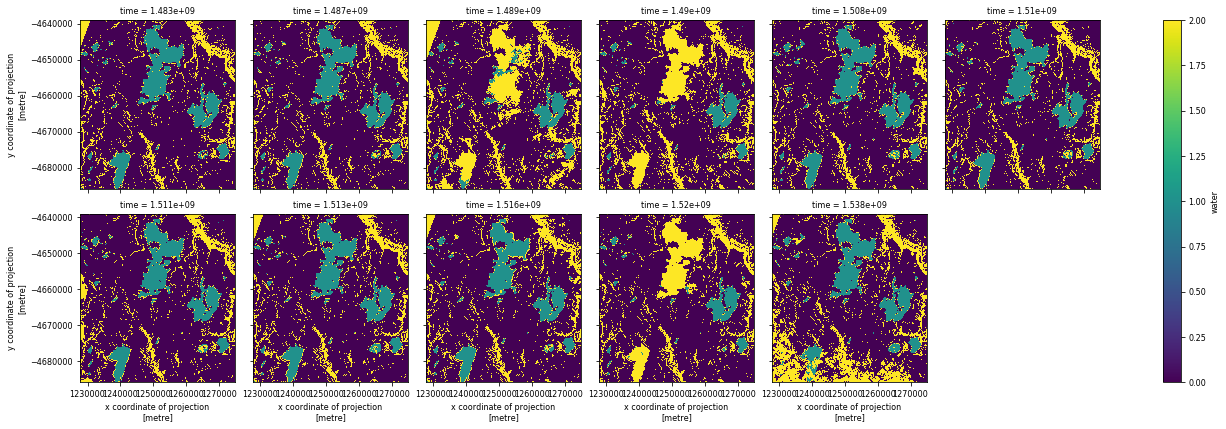

In [12]:
clean_2.water.plot(col='time', col_wrap=6, robust=True)

In [13]:
len(clean_1.time), len(clean_2.time)

(18, 11)

In [14]:
clean_1_orig = make_data('george', addfeature=False)
threshold_vh(clean_1_orig, band = 'hist_classified')
clean_1['hist_classified'] = ('time', 'y', 'x'), clean_1_orig['hist_classified'].values
result_1['hist_classified'] = clean_1['hist_classified'].where(result_1.water.values<2).copy()
result_1['hist_classified_2'] = result_1.hist_classified.where(result_1.hist_classified<=result_1.water,2).where(result_1.hist_classified>=result_1.water,3).where(result_1.water<2)

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


In [15]:
clean_2_orig = make_data('tasmania', addfeature=False)
threshold_vh(clean_2_orig, band = 'hist_classified', min_perc=0.1)
clean_2['hist_classified'] = ('time', 'y', 'x'), clean_2_orig['hist_classified'].values
result_2['hist_classified'] = clean_2['hist_classified'].where(result_2.water.values<2).copy()
result_2['hist_classified_2'] = result_2.hist_classified.where(result_2.hist_classified<=result_2.water,2).where(result_2.hist_classified>=result_2.water,3).where(result_2.water<2)

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


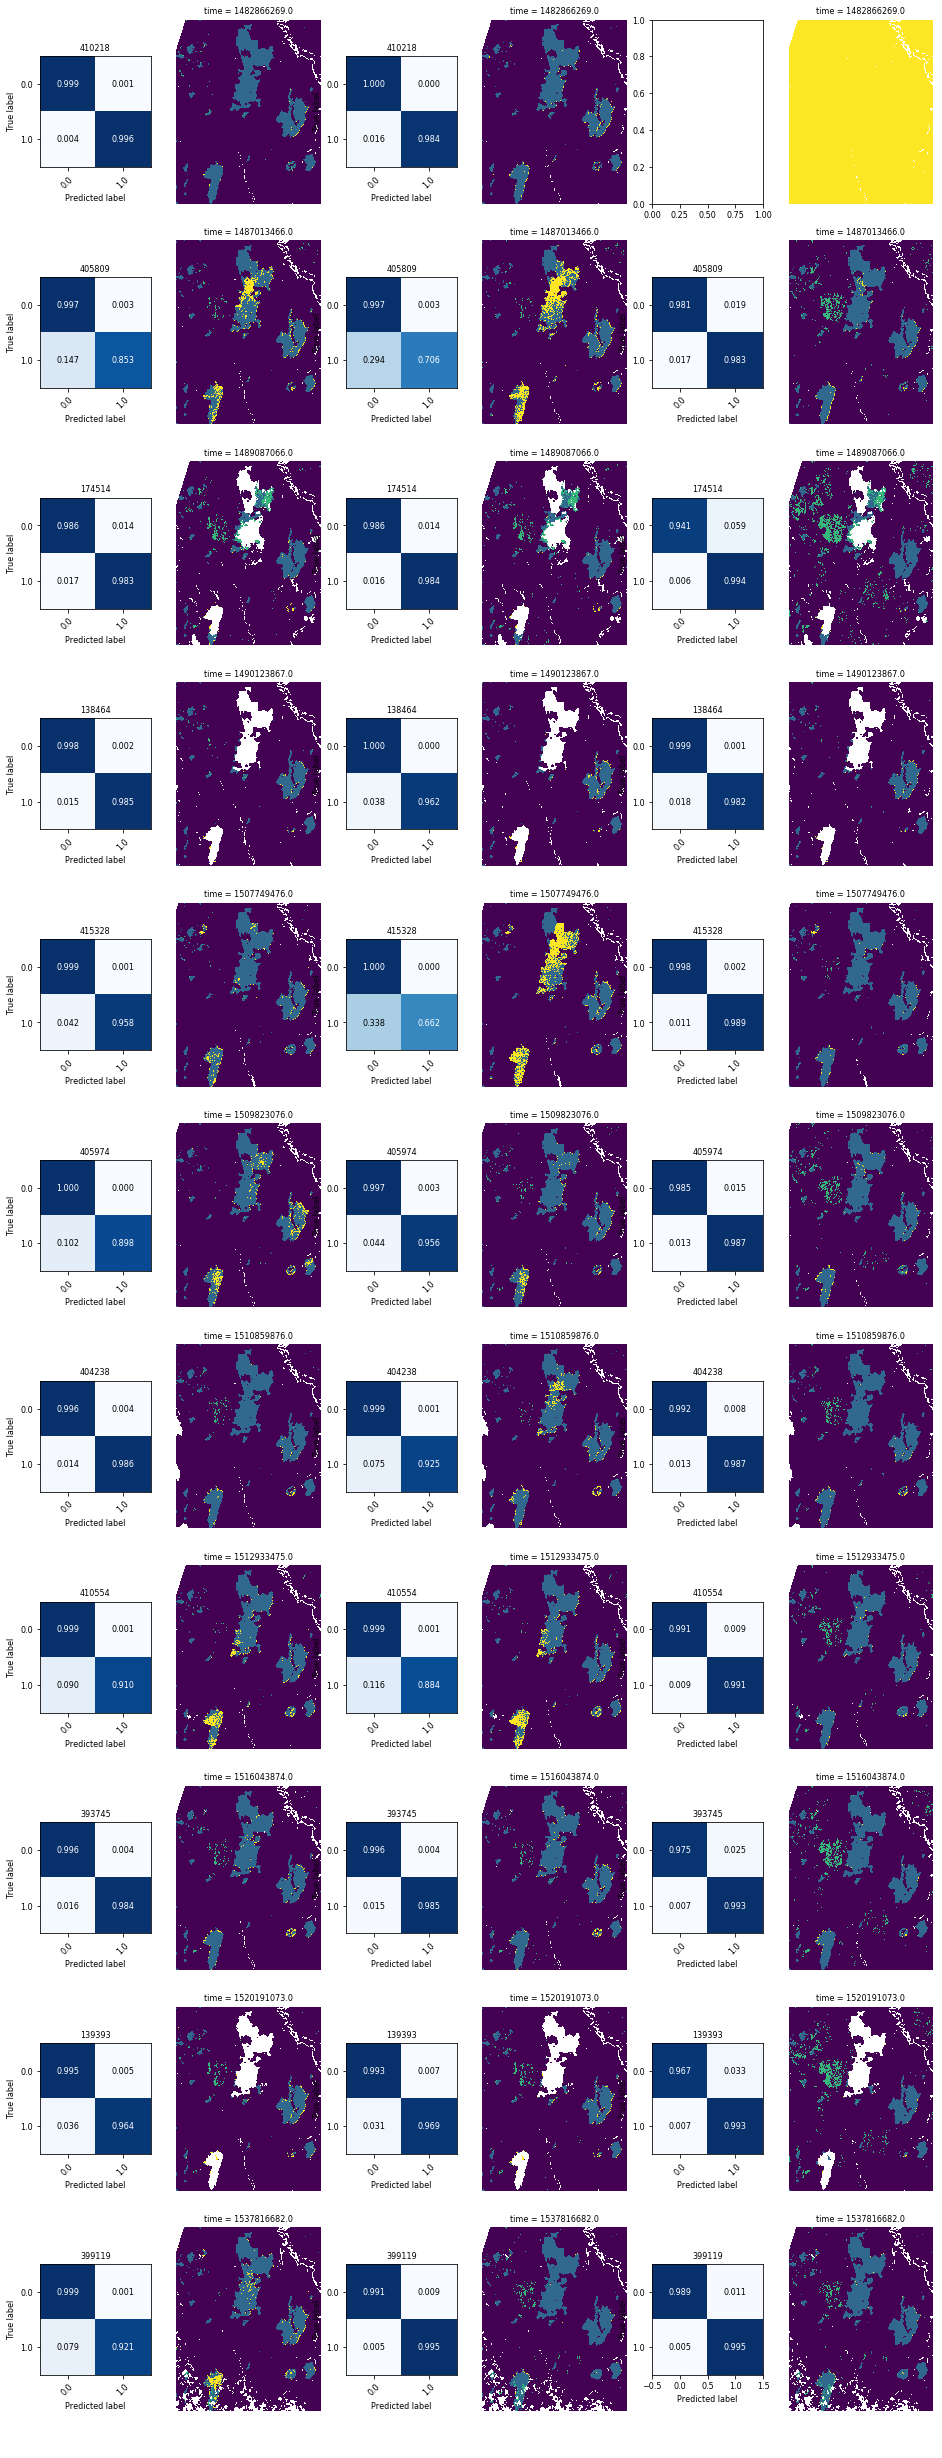

In [16]:
result = result_2
fig, ax = plt.subplots(ncols = 6, nrows=int(np.ceil(len(result.time)*6/6)), 
                       gridspec_kw= {'width_ratios':[1,1.3,1,1.3,1.,1.3]},
                       figsize=(16,16*len(result.time)/4))
for i in range(len(result.time)):
    pred = result.brf_classified.isel(time=i).values.ravel()
    y = result.water.isel(time=i).values.ravel()
    good = ~np.isnan(y)
    pred= pred[good]
    y = y[good]
    good = ~np.isnan(pred)
    pred= pred[good]
    y = y[good]
    cm = confusion_matrix(y, pred)
    plot_confusion_matrix(cm, classes=np.unique(y), ax=ax[i,0], normalize=True,
                      title='%d'%(y==1).sum())
    
    result.brf_classified_2.isel(time=i).plot(ax=ax[i,1], add_colorbar=False, vmin=0, vmax=3)
    ax[i,1].set_axis_off()
    
    pred = result.rusboost_classified.isel(time=i).values.ravel()
    y = result.water.isel(time=i).values.ravel()
    good = ~np.isnan(y)
    pred= pred[good]
    y = y[good]
    good = ~np.isnan(pred)
    pred= pred[good]
    y = y[good]
    cm = confusion_matrix(y, pred)
    plot_confusion_matrix(cm, classes=np.unique(y), ax=ax[i,2], normalize=True,
                      title='%d'%(y==1).sum())
    
    result.rusboost_classified_2.isel(time=i).plot(ax=ax[i,3], add_colorbar=False, vmin=0, vmax=3)
    ax[i,3].set_axis_off()
    
    pred = result.hist_classified.isel(time=i).values.ravel()
    y = result.water.isel(time=i).values.ravel()
    good = ~np.isnan(y)
    pred= pred[good]
    y = y[good]
    good = ~np.isnan(pred)
    pred= pred[good]
    y = y[good]
    if len(y)>0:
        cm = confusion_matrix(y, pred)
        plot_confusion_matrix(cm, classes=np.unique(y), ax=ax[i,4], normalize=True,
                      title='%d'%(y==1).sum())
    
    result.hist_classified_2.isel(time=i).plot(ax=ax[i,5], add_colorbar=False, vmin=0, vmax=3)
    ax[i,5].set_axis_off()
    
fig.savefig('apsar_result_brf_rusboost_hist_%s.png'%feature_set)

In [17]:
def make_cm(classified, water):
    pred = classified.values.ravel()
    y = water.values.ravel()
    good = ~np.isnan(y)
    pred= pred[good]
    y = y[good]
    good = ~np.isnan(pred)
    pred= pred[good]
    y = y[good]
    return confusion_matrix(y, pred)

In [18]:
cms={}
for model in ['brf', 'rusboost', 'hist']:
    cms[model] = {'Lake George': make_cm(result_1['%s_classified'%model], result_1.water)}
    cms[model]['Tasmania'] =  make_cm(result_2['%s_classified'%model], result_2.water)

In [19]:
use_1= (result_1['hist_classified']==1).groupby('time').sum()>0
use_2= (result_2['hist_classified']==1).groupby('time').sum()>0

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


In [20]:
matched_cms={}
for model in ['brf', 'rusboost', 'hist']:
    matched_cms[model] = {'Lake George': make_cm(result_1['%s_classified'%model].isel(time=use_1), result_1.water.isel(time=use_1))}
    matched_cms[model]['Tasmania'] =  make_cm(result_2['%s_classified'%model].isel(time=use_2), result_2.water.isel(time=use_2))

In [21]:
cms

{'brf': {'Lake George': array([[18863278,   913974],
         [   51178,  1398157]]), 'Tasmania': array([[29214380,    97256],
         [  210706,  3486650]])},
 'rusboost': {'Lake George': array([[18830372,   946880],
         [   58400,  1390935]]), 'Tasmania': array([[29200128,   111508],
         [  382504,  3314852]])},
 'hist': {'Lake George': array([[10133349,  1271721],
         [   54226,  1391691]]), 'Tasmania': array([[26116246,   479087],
         [   34794,  3252344]])}}

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


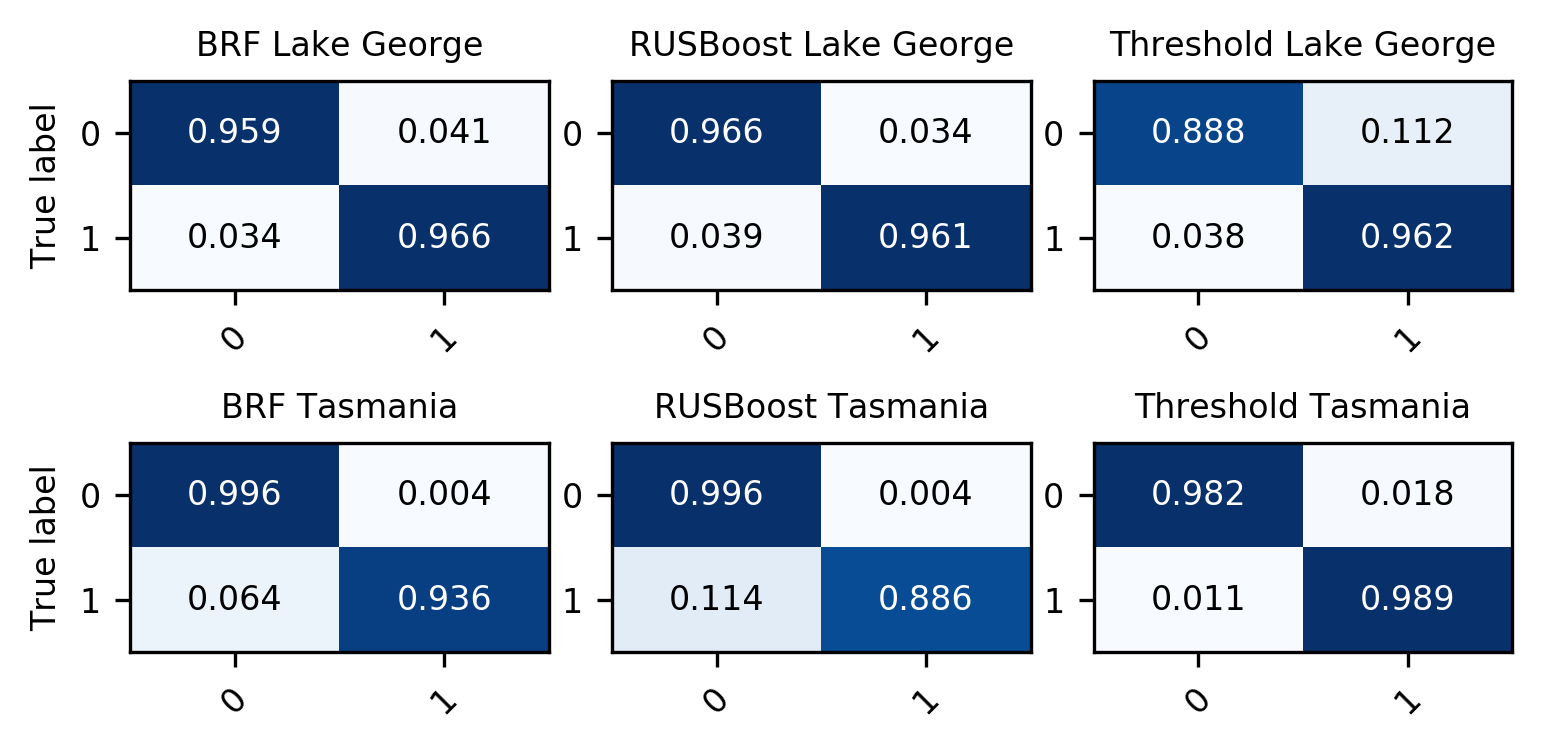

In [30]:
fig, ax = plt.subplots(ncols = 3, nrows=2, figsize = (4.8,2.4), dpi=300,
                       gridspec_kw={'left':0.02, 'right':0.98, 'top':0.98, 'bottom':0.02,
                                    'wspace':0.15, 'hspace':0.1})

classifiers = {'brf':'BRF', 'rusboost':'RUSBoost', 'hist':'Threshold'}
for i, model in enumerate(['brf', 'rusboost', 'hist']):
    for j, area in enumerate(['Lake George', 'Tasmania']):
        plot_confusion_matrix(matched_cms[model][area], classes=[0,1], ax=ax[j,i], normalize=True,
                      title='%s %s'%(classifiers[model], area), flat=True)
        if i>0: ax[j,i].set_ylabel('')
        if j<2: ax[j,i].set_xlabel('')
    
fig.tight_layout()
fig.savefig('apsar_test_brf_rusboost_hist_%s.png'%feature_set, format='png', dpi=300, bbox_inches='tight')
fig.savefig('apsar_test_brf_rusboost_hist_%s.tiff'%feature_set, format='tiff', dpi=300, bbox_inches='tight')

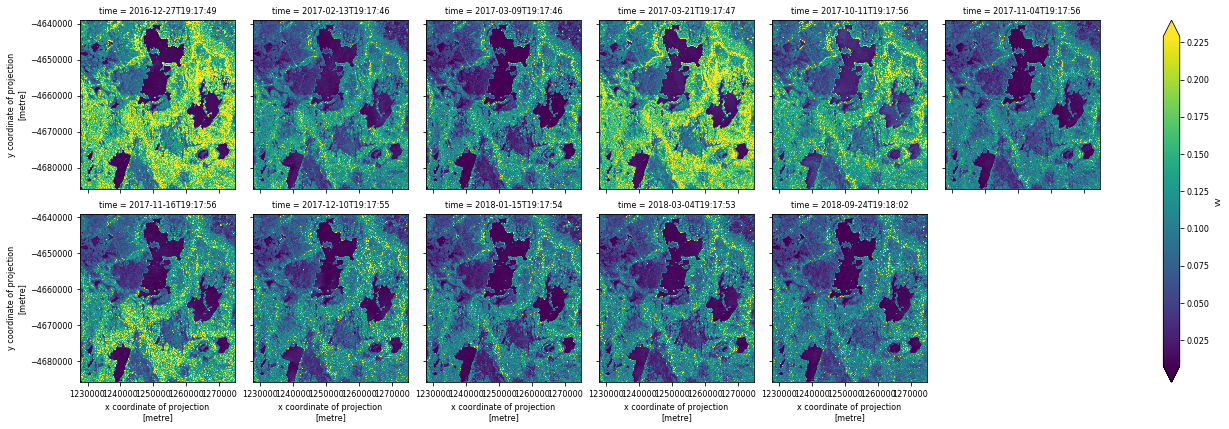

In [23]:
clean_2_orig.vv.plot(col='time', col_wrap=6,robust=True)

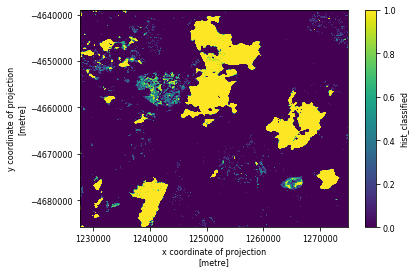

In [24]:
clean_2.hist_classified.mean(dim='time').plot()

In [25]:
dc= datacube.Datacube()
def ls_and_sar_rgb(area):
    wofs = xr.open_dataset('apsar_s1_water_train_wofs_%s.nc'%area)
    example_index = (wofs.water==1).groupby('time').mean().argmax()
    ls8_time = wofs.time.values[example_index]
    print(ls8_time)
    ls8 = dc.load(product='ls8_nbart_albers',
                  x=(wofs.x[0].values,wofs.x[-1].values),
                  y=(wofs.y[0].values,wofs.y[-1].values), crs='EPSG:3577',
                  time=(str(ls8_time)[:10],str(ls8_time+np.timedelta64(1,'D'))[:10]),
                  measurements=['red','green','blue'],
                  group_by='solar_day')

    clean_1 = xr.open_dataset('apsar_s1_water_train_s1_%s.nc'%area)
    clean_1_example = clean_1.isel(time=example_index).copy()
    clean_1_example['vh/vv']=clean_1_example.vh/clean_1_example.vv
    med = clean_1_example[['vh','vv','vh/vv']].median()
    return ls8, clean_1_example[['vh','vv','vh/vv']]/med

ls8_1, sar_1 = ls_and_sar_rgb('george')
ls8_2, sar_2 = ls_and_sar_rgb('tasmania')

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


2016-12-06T23:50:36.000000000


/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


2017-10-06T23:52:33.000000000


/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


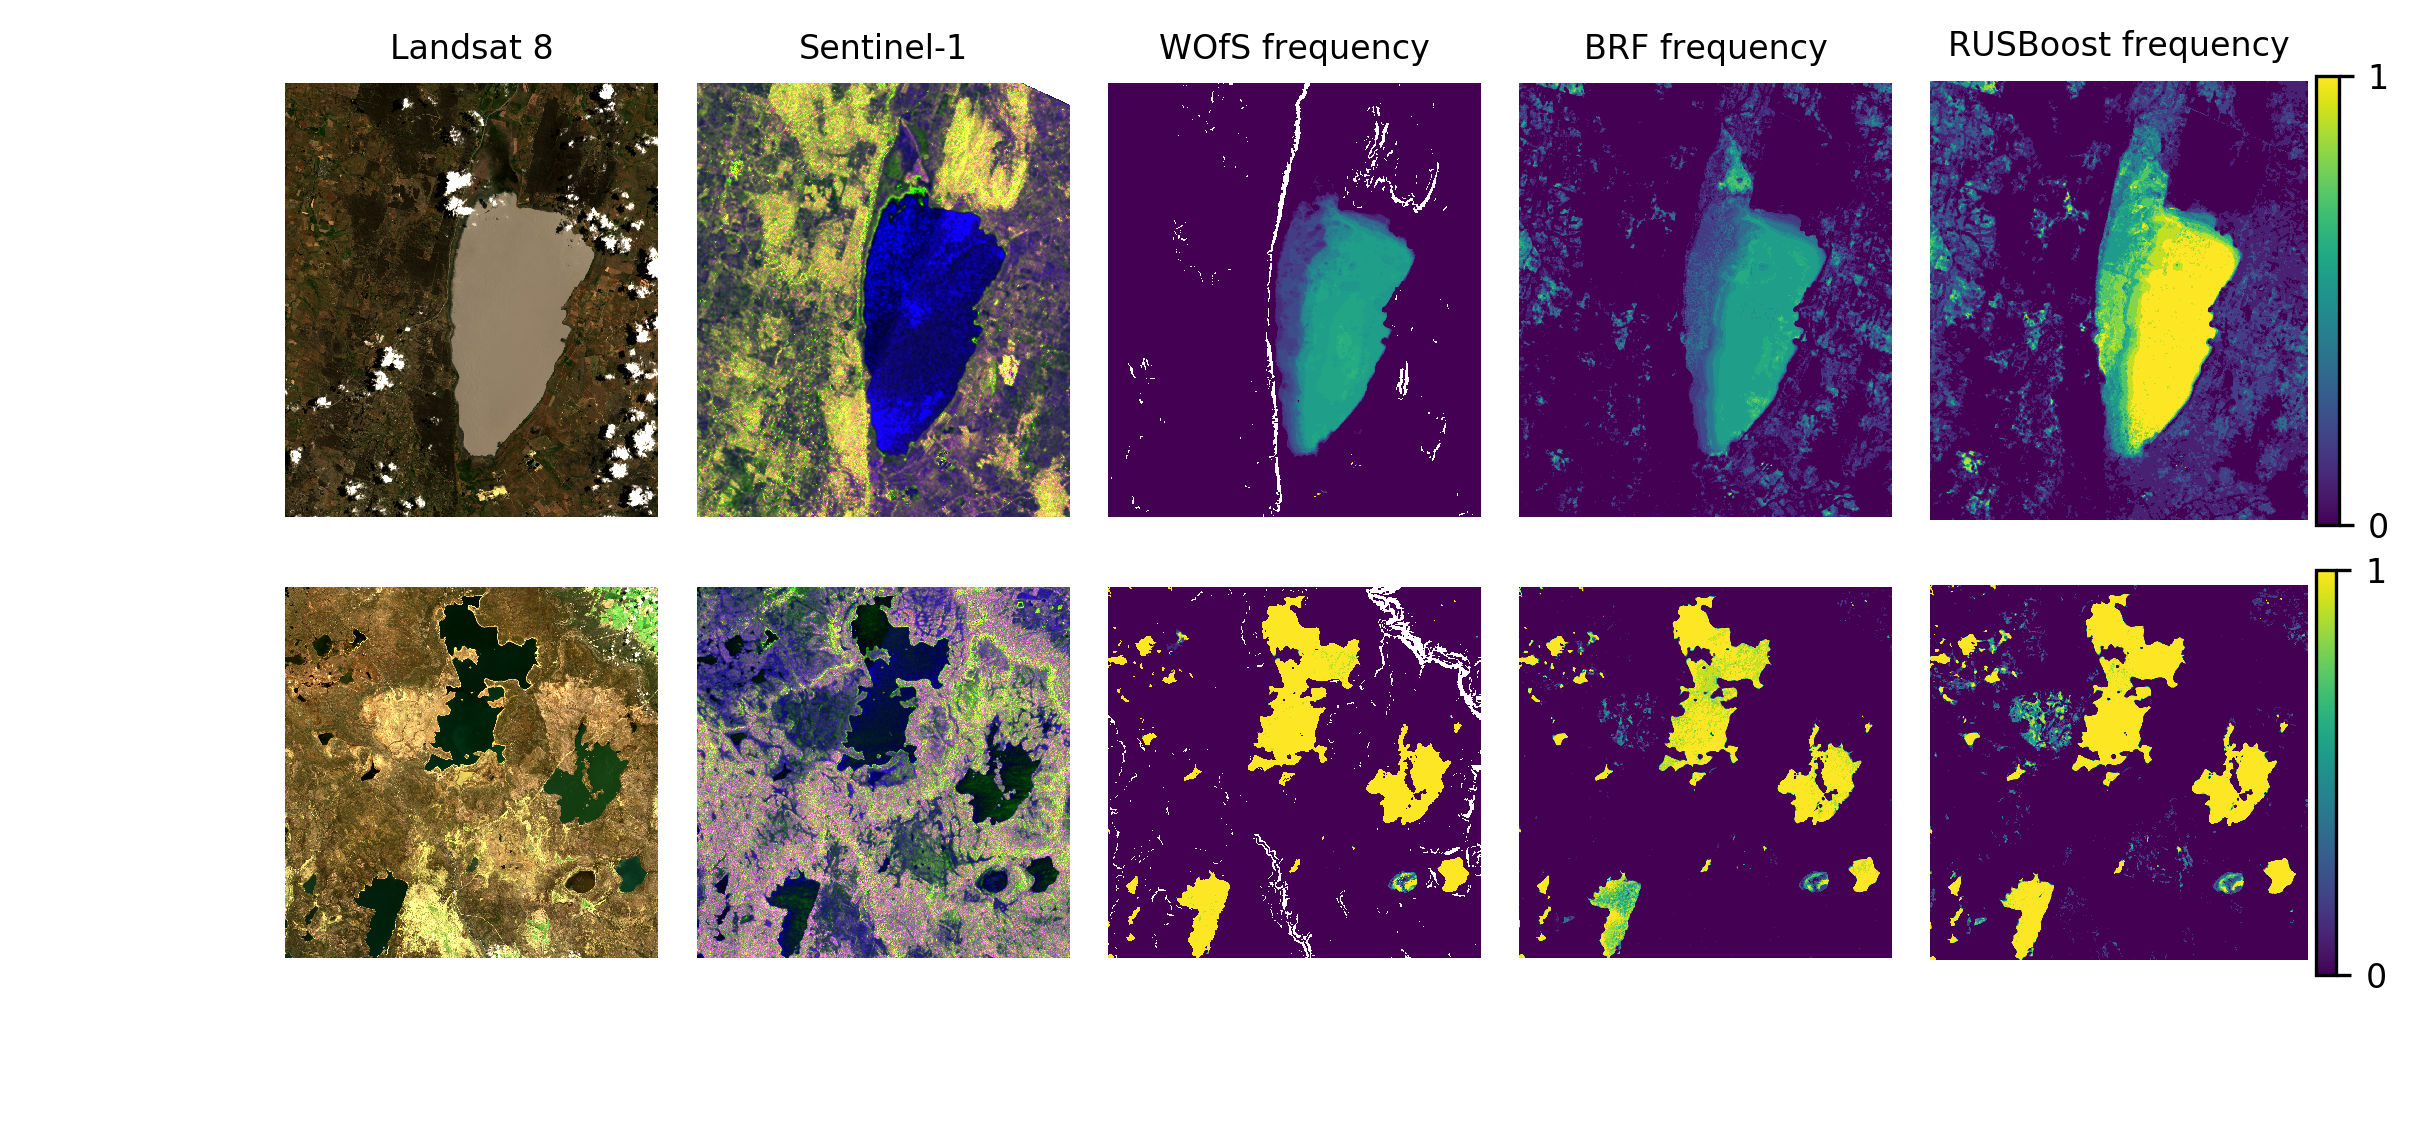

In [29]:
fig, ax  = plt.subplots(ncols=5, nrows =2, figsize = (7.2,3.2), dpi=300,
                        gridspec_kw={'left':0.02, 'right':0.98, 'top':0.98, 'bottom':0.02,
                        'wspace':0.1, 'hspace':0.05, 'width_ratios':[1.,1.,1.,1., 1.15]}
                       )
clean_1['WOfS'] = clean_1.water.where(clean_1.water<2)
clean_2['WOfS'] = clean_2.water.where(clean_2.water<2)


ls8_1.isel(time=0).to_array().plot.imshow(robust=True,ax=ax[0,0])
ax[0,0].set_title('Landsat 8')
ax[0,0].set_axis_off()
ax[0,0].set_aspect('equal')
ax[0,0].margins(0.0)

sar_1.to_array().plot.imshow(robust=True,ax=ax[0,1])
ax[0,1].set_title('Sentinel-1')
ax[0,1].set_axis_off()
ax[0,1].set_aspect('equal')
ax[0,1].margins(0.0)

ls8_2.isel(time=0).to_array().plot.imshow(robust=True,ax=ax[1,0])
ax[1,0].set_title('')
ax[1,0].set_axis_off()
ax[1,0].set_aspect('equal')
ax[1,0].margins(0.0)

sar_2.to_array().plot.imshow(robust=True,ax=ax[1,1])
ax[1,1].set_title('')
ax[1,1].set_axis_off()
ax[1,1].set_aspect('equal')
ax[1,1].margins(0.0)


for i, band in enumerate(['WOfS', 'brf_classified', 'hist_classified']):
    if i==2: clean_1[band].mean(dim='time').plot(ax=ax[0, i+2], vmin=0, vmax=1, 
                                                 cbar_kwargs={'label':'','ticks':[0,1],'fraction':0.1,
                                                              #'shrink':0.9,
                                                           'pad':0.02,'format':'%.0f'})
    else:clean_1[band].mean(dim='time').plot(ax=ax[0, i+2], vmin=0, vmax=1, add_colorbar=False)
    if i==2: clean_2[band].mean(dim='time').plot(ax=ax[1, i+2], vmin=0, vmax=1, 
                                                 cbar_kwargs={'label':'','ticks':[0,1],'fraction':0.1,
                                                              'shrink':0.9,
                                                           'pad':0.02,'format':'%.0f'})
    else:clean_2[band].mean(dim='time').plot(ax=ax[1, i+2], vmin=0, vmax=1, add_colorbar=False)
    ax[0, i+2].set_axis_off()
    ax[1, i+2].set_axis_off()
    ax[0,i+2].set_aspect('equal')
    ax[1,i+2].set_aspect('equal')

    
ax[0, 2].set_title('WOfS frequency')
ax[0, 3].set_title('BRF frequency')
ax[0, 4].set_title('RUSBoost frequency')

    
fig.savefig('apsar_summay_brf_hist_%s.png'%feature_set, format='png', dpi=300, bbox_inches='tight')
fig.savefig('apsar_summay_brf_hist_%s.tiff'%feature_set, format='tiff', dpi=300, bbox_inches='tight')

In [27]:
feature_set

'rel'